<a href="https://colab.research.google.com/github/vjmeraz/af2rave-tutorial/blob/master/DDR1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Installation

In [6]:
!pip install -q condacolab
import condacolab
condacolab.install()

!conda install -q pdbfixer mdtraj openmm
!git clone https://github.com/tiwarylab/af2rave.git
!pip install af2rave/

!git clone https://github.com/vjmeraz/af2rave-tutorial.git

✨🍰✨ Everything looks OK!
Channels:
 - conda-forge
Platform: linux-64
Solving environment: ...working... done

# All requested packages already installed.

fatal: destination path 'af2rave' already exists and is not an empty directory.
Processing ./af2rave
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for af2rave: filename=af2rave-0.1.0-py3-none-any.whl size=74010 sha256=60e39af49b44480e2b0a8b3a5a7b5fe73ab0a9240141b3fa105ef1b5cb8322eb
  Stored in directory: /tmp/pip-ephem-wheel-cache-jlw2_50i/wheels/95/5a/67/5ca4979aac4da116f99687d881564441364f794a29562c04c6
Successfully built af2rave
  Attempting uninstall: af2rave
    Found existing installation: af2rave 0.1.0
    Uninstalling af2rave-0.1.0:
      Successfully uninstalled af2rave-0.1.0
fatal: destination path 'af2rave-tutorial' already exists and is not an empty directory.


# Base Imports

In [7]:
import glob
from natsort import natsorted

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 30})

# Colvar file object

The Colvar class allows for a plumed style colvar.dat file to be read and edited. Some examples will be covered in this section.

In [8]:
from af2rave import Colvar

In [ ]:
# preset data from unbiased sim output
files = natsorted(glob.glob("af2rave-tutorial/data/colvars/*.dat")) # colvar files produced by simulation
# files

['af2rave-tutorial/data/colvars/colvar_1.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_1.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_2.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_3.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_4.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_5.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_6.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_7.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_8.dat',
 'af2rave-tutorial/data/colvars/reduced_colvar_9.dat']

we can create a Colvar object in the following way:


```
Colvar.from_file(path_to_file)
```

In [ ]:
colvar = Colvar.from_file(files[0]) # creates a Colvar object from a (plumed style colvar.dat) file


The colvar.dat file can be read in the following ways:

```
Colvar().read(path_to_file)
```

```
colvar = Colvar.from_file(path_to_file)
colvar.read(path_to_file)
```



To print the file's header:

```
colvar = Colvar.from_file(path_to_file)
colvar._get_header_from_file()
```



we can also read the colvar.dat file with a stride:

```
colvar = Colvar.from_file(path_to_file)
colvar.read(path_to_file, stride)
```


we can write a new colvar.dat file:

```
colvar = Colvar.from_file(path_to_file)
colvar.read(path_to_file, stride).write(new_filename)
```

```
colvar = Colvar.from_file(path_to_file)
read_colvar = colvar.read(path_to_file, stride)
read_colvar.write(new_filename)
```



In [ ]:
# reading simulation data with a stride and saving it

read_colvar = colvar.read(files[0], stride=100) # reads colvar file with a data stride
read_colvar.write("colvar_stride.dat") # writes new colvar file

print("original data shape: ", np.genfromtxt(files[0]).shape)
print("strided data shape: ", np.genfromtxt("colvar_stride.dat").shape)

original data shape:  (10000, 201)
strided data shape:  (100, 201)


# Running an Unbiased Simulation

In [ ]:
import af2rave.simulation as sim

To run an unbiased simulation, only two inputs are required: `a pdb file` and a `list of indices (used to calculate CVs)`

In [ ]:
pdb0 = "af2rave/datasets/DDR1_MSA8/pred_1.pdb" # path to sample pdb
idx = np.load("af2rave-tutorial/data/idx.npy", allow_pickle=True) # list of indices

from the pdb file, we can create the simulation box and solvate the system with water

In [ ]:
box = sim.SimulationBox(pdb0)
box.create_box()
box.save_pdb(f"boxed_pred_1.pdb") # save simulation box as a pdb file to be used as input

In [ ]:
pdb = "boxed_pred_1.pdb"
unbiased = sim.UnbiasedSimulation(pdb, # pdb file input with box
                                  list_of_index=idx,
                                  xtc_freq=5000, # save frequency for xtc file
                                  cv_freq=50) # save frequency for CV
unbiased.run(10000) # 0.2 ns
unbiased.save_pdb() # pdb save after simulation end
unbiased.save_checkpoint() # final simulation checkpoint

# [AMINO](https://github.com/tiwarylab/amino): Automatic Mutual Information Noise Omission

The `af2rave.amino` module is a wrapper of the original framework by [Ravindra, Smith, and Tiwary](https://doi.org/10.1039/C9ME00115H)



In [ ]:
import af2rave.amino as amino

To get the *best* order parameters, as determined by AMINO we use `amino.AMINO.from_file(path_to_cv_files, n)`. Multiple files can be input as a list. Parameter `n` is the upper bound for best features to be selected

to print the resulting list of CVs we use `amino.AMINO.from_file(path_to_cv_files, n).result`

In [ ]:
cv_file = "colvar_stride.dat" # file used to run amino, can be a list of files
a = amino.AMINO.from_file(cv_file, n=8) # run amino
a.result # amino result as a list

DM construction time: 152.81 s


['dist_2956_3511', 'dist_2530_2928']

`amino.AMINO.from_file(path_to_cv_files, n).result` provides a header style output we can use to edit the initial colvar.dat files

we can select the data columns from a colvar.dat file with `Colvar.from_file(path_to_colvar_dat).choose(amino_result)` and write or rewrite a colvar.dat file as in the cell below

In [ ]:
headers = a.result
cv_read = Colvar.from_file(cv_file) # read original cv file
cv = cv_read.choose(headers) # reads columns in colvar file corresponding to file header
cv.write(f"colvar_amino.dat") # writes colvar file with reduced

# [SPIB](https://github.com/tiwarylab/State-Predictive-Information-Bottleneck): State Predictive Information Bottleneck

The `af2rave.spib` module is a wrapper of the original framework by [Wang and Tiwary](https://aip.scitation.org/doi/abs/10.1063/5.0038198)




In [ ]:
import af2rave.spib as af2spib

we first preprocess data with `af2spib.SPIBProcess`. This module takes colvar.dat files, normalizes that data, and creates SPIB labels for it

```
af2spib.SPIBProcess(files)
```
for SPIB to run the only parameter input *required* is the time lag, Δt

```
spib = af2spib.SPIBProcess(files)
spib.run(time_lag)
```

we can save this result into a pickle file --- in place of the folder created by SPIB  
```
spib = af2spib.SPIBProcess(files)
result = spib.run(time_lag)
result.to_file(filename.pickle)
```


In [ ]:
files = natsorted(glob.glob("af2rave-tutorial/data/colvars/reduced*.dat")) # colvar files from unbiased trajetory runs
spib = af2spib.SPIBProcess(files)
dt = 25000

result = spib.run(time_lag = dt,
                  batch_size = 512,
                  neuron_num1 = 32,
                  neuron_num2 = 128,
                  threshold = 0.05,
                  refinements = 5,
                  beta = 1e-3,
                  lr_scheduler_gamma = 0.8,
                  learning_rate = 1e-5,
                  )

result.to_file(f"dt_{dt}.pickle")

# SPIB Outputs

most (if not all!) SPIB outputs exist in the pickle file created

we can read it:

```
af2spib.SPIBResult.from_file(path_to_pickle)
```

and see values stored for any parameter

```
result = af2spib.SPIBResult.from_file(path_to_pickle)
result._dt
result._n_traj
result._representatives["inputs"]
...
```



In [ ]:
files = glob.glob(f"dt_*.pickle")
result = af2spib.SPIBResult.from_file(files[0])

Text(0.5, 0, 'Input OP')

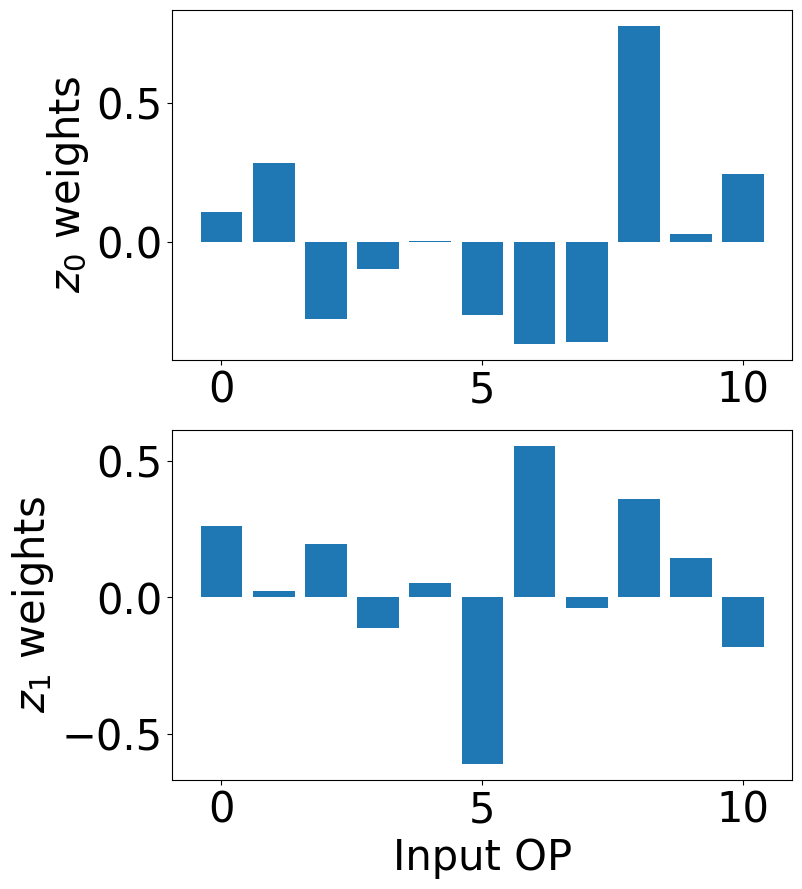

In [ ]:
weight0, weight1 = result._z_mean_encoder["weight"]

plt.figure(figsize=(8, 10))
plt.subplot(2,1,1)
plt.bar(range(len(weight0)),weight0)
plt.ylabel("$z_0$ weights")

plt.subplot(2,1,2)
plt.bar(range(len(weight1)),weight1)
plt.ylabel("$z_1$ weights")
plt.xlabel("Input OP")

# Latent Space Projections

To plot the free energy from our output, we can use `result.get_free_energy()`

We can also project SPIB results into latent space using `result.get_latent_representation()`


The following plots provide some examples on how they can be used



/usr/local/lib/python3.10/site-packages/af2rave/spib/spib_result.py:202: RuntimeWarning: divide by zero encountered in log
  f = -np.log(h)
<ipython-input-16-bc2fa9ec8e41>:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cbar = fig.colorbar(im)


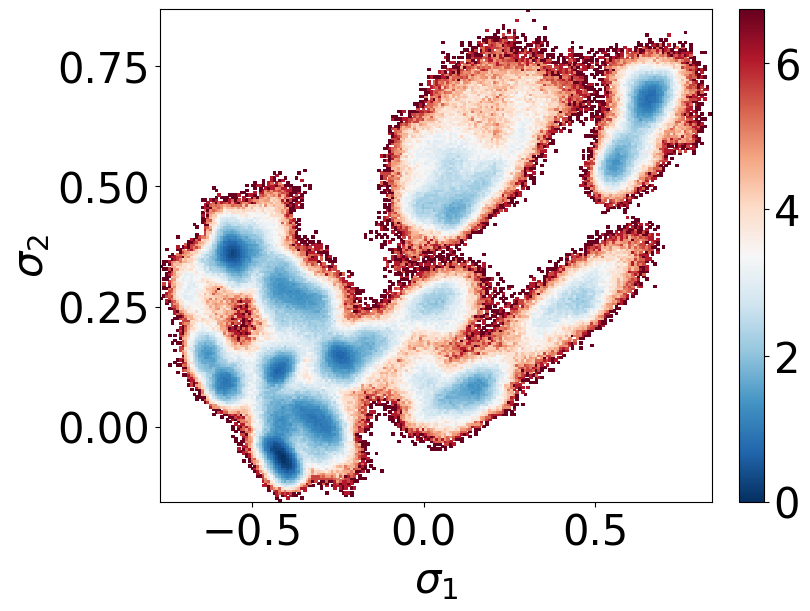

In [ ]:
# free energy
fig, ax = plt.subplots(figsize=(8,6), layout='compressed')

im = ax.pcolor(*result.get_free_energy(), cmap="RdBu_r", shading="auto")

ax.set_xlabel(r"$\sigma_1$")
ax.set_ylabel(r"$\sigma_2$")
cbar = fig.colorbar(im)
plt.show()

to label the latent space as a function of SPIB labels we can use `result.get_state_label()` for the plotting parameter `c`

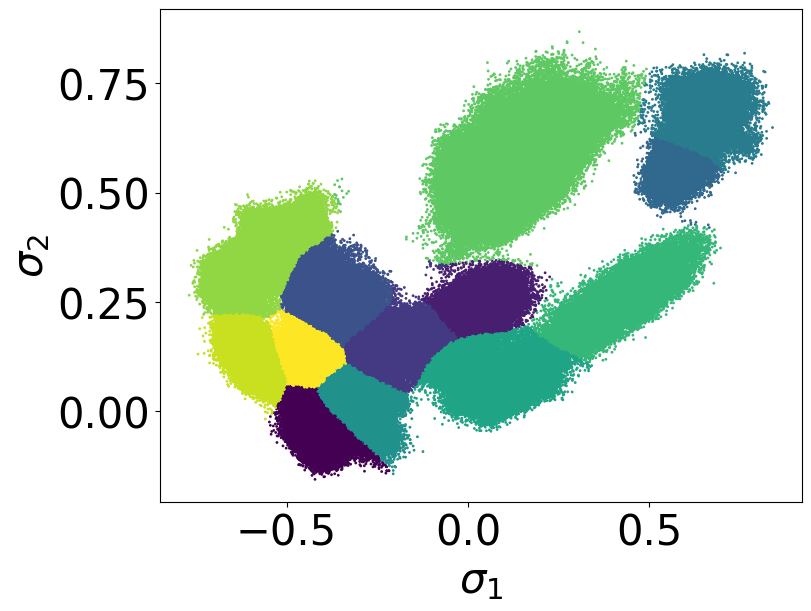

In [ ]:
# spib labels
fig, ax = plt.subplots(figsize=(8,6), layout='compressed')

im = ax.scatter(*result.get_latent_representation(), c=result.get_state_label(), s=1)

ax.set_xlabel(r"$\sigma_1$")
ax.set_ylabel(r"$\sigma_2$")
plt.show()

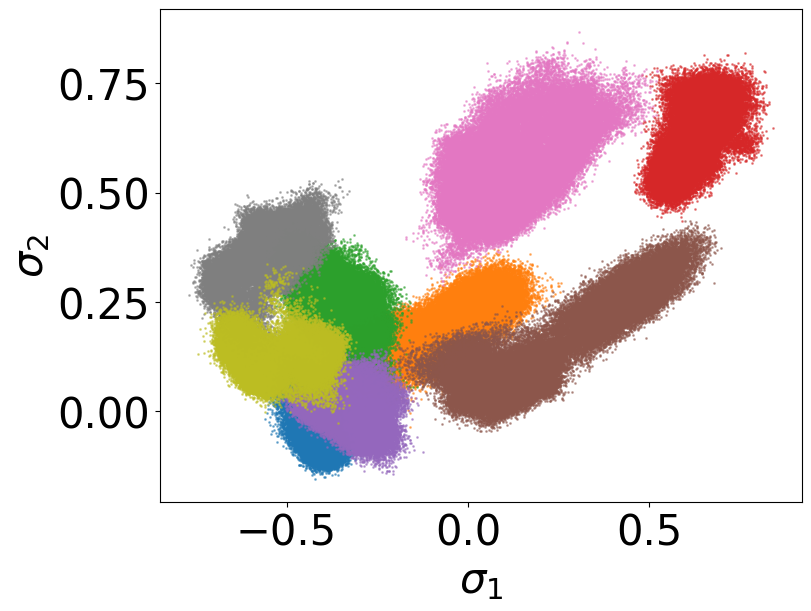

In [ ]:
# trajectories
fig, ax = plt.subplots(figsize=(8,6), layout='compressed')
for k in range(9): # 9 = number of unbiased simulation trajectories

    x, y = result.get_latent_representation(k)

    im = ax.scatter(x, y, c=f"C{k}", s=1, alpha=0.5)
    ax.set_xlabel(r"$\sigma_1$")
    ax.set_ylabel(r"$\sigma_2$")
plt.show()

We can also make projections with colvar.dat data. First, data is read and stored with `data_variable = Colvar.from_file(path_to_dat).data`. The SPIB result from the pickle stored in `result` can be projected with `result.project(data_variable)`

The following plots show examples of projections with colvar.dat data


In [ ]:
# projections

def labels_int_to_str(labels):
  label_dict={1:'DFG_in', 2:'Unassigned', -1:'DFG_out', 0:'DFG_inter'}
  labels_str=[label_dict[label] for label in labels]
  return labels_str

def get_dfglabel(d1,d2):
  labels=2*np.ones(d1.shape[0])
  ind1=np.where(d1<=11)[0]
  labels[ind1]=1
  ind2=np.where(d2[ind1]<=11)[0]
  labels[ind1[ind2]]=0
  ind3=np.where(d1>11)[0]
  ind4=np.where(d2[ind3]<=14)[0]
  labels[ind3[ind4]]=-1
  return labels


dist = Colvar.from_file("af2rave-tutorial/data/rmsa/distances.dat").data
sb, d1, d2 = Colvar.from_file("af2rave-tutorial/data/rmsa/objs.dat").data
rmsa = result.project(dist)
dfg_labels = get_dfglabel(d1, d2)

color = "hot"

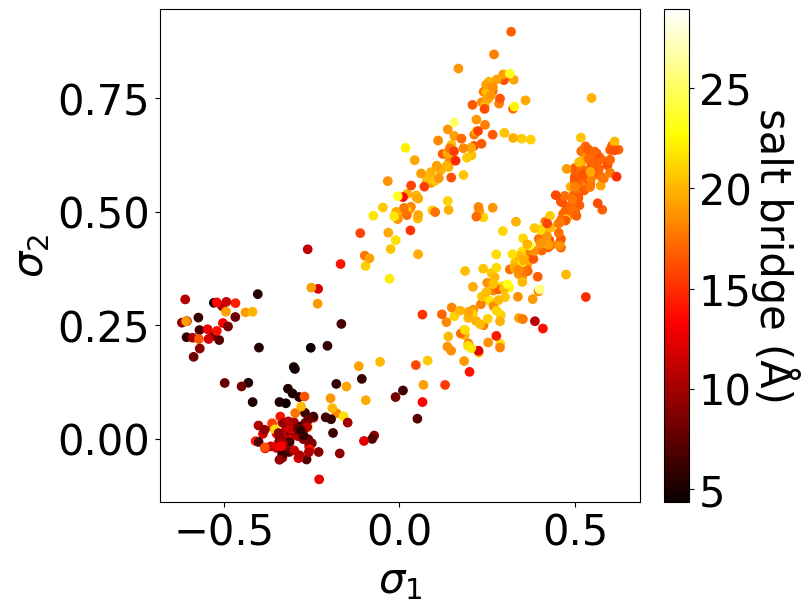

In [ ]:
fig, ax = plt.subplots(figsize=(8,6), layout='compressed')
im = ax.scatter(*rmsa,c=sb, cmap=color)
ax.set_xlabel(r"$\sigma_1$")
ax.set_ylabel(r"$\sigma_2$")
cbar = fig.colorbar(im)
cbar.set_label('salt bridge (Å)', rotation=270, labelpad=35)
plt.show()

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), layout='compressed')

dfg_in = ax[0].scatter(*rmsa[:,np.where(dfg_labels==1)], marker="o", label="in", color="cornflowerblue", alpha=0.5)
dfg_inter = ax[0].scatter(*rmsa[:,np.where(dfg_labels==0)], marker="p", label="inter", color="purple", alpha=0.5)
dfg_out = ax[0].scatter(*rmsa[:,np.where(dfg_labels==-1)], marker="*", label="out", color='lime', alpha=0.5)
dfg_un = ax[0].scatter(*rmsa[:,np.where(dfg_labels==2)], marker="$?$", label="unassigned", color='k')
ax[0].set_title(r"DFG labels")
ax[0].set_xlabel(r"$\sigma_1$")
ax[0].set_ylabel(r"$\sigma_2$")

ax[1].axis("off")
ax[1].legend(handles=[dfg_in, dfg_inter, dfg_out, dfg_un], loc='center', markerscale=3)

plt.show()

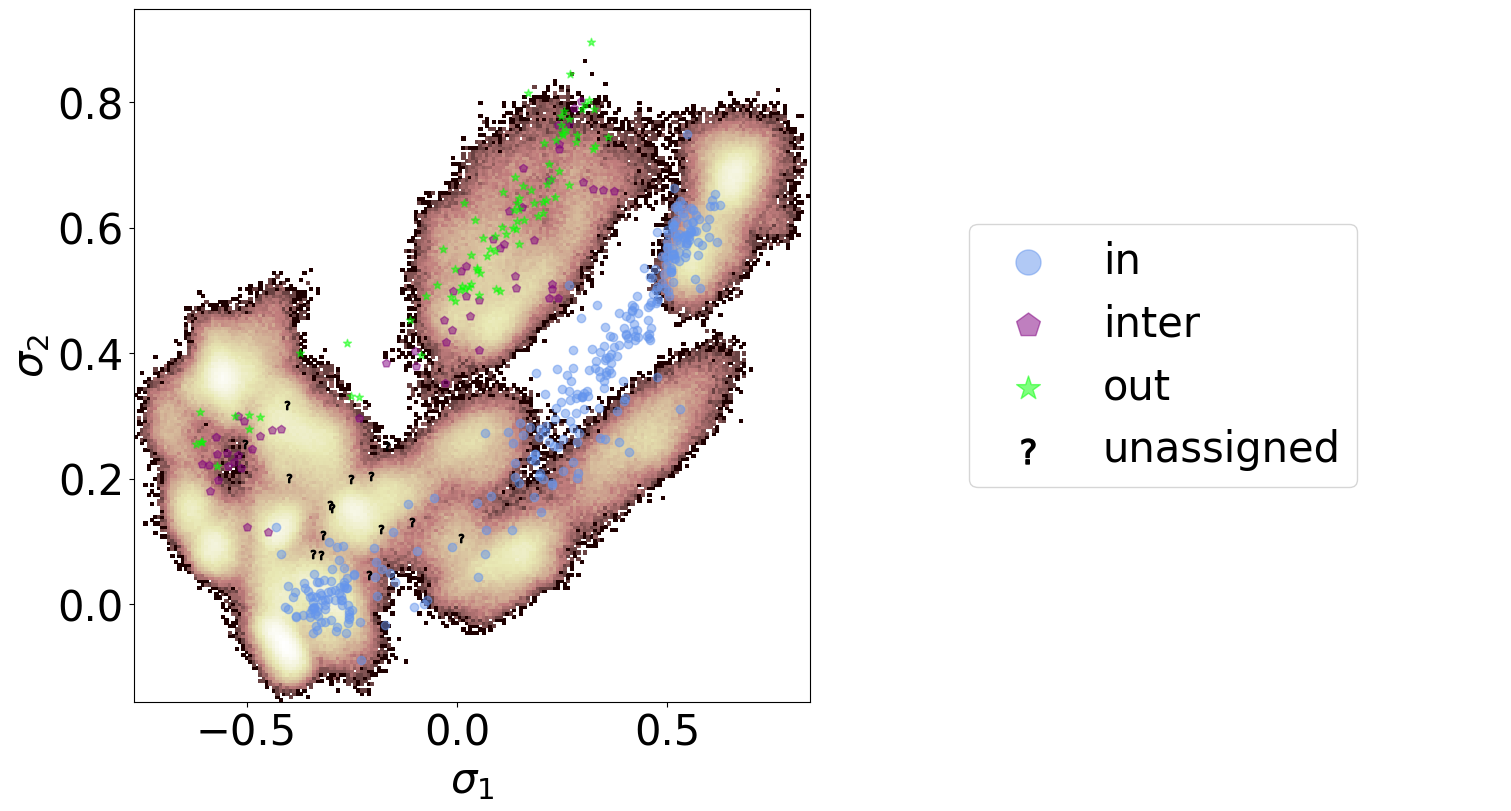

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(15,8), layout='compressed')


im = ax[0].pcolor(*result.get_free_energy(), cmap="pink_r", shading="auto")


dfg_in = ax[0].scatter(*rmsa[:,np.where(dfg_labels==1)], marker="o", label="in", color="cornflowerblue", alpha=0.5)
dfg_inter = ax[0].scatter(*rmsa[:,np.where(dfg_labels==0)], marker="p", label="inter", color="purple", alpha=0.5)
dfg_out = ax[0].scatter(*rmsa[:,np.where(dfg_labels==-1)], marker="*", label="out", color='lime', alpha=0.5)
dfg_un = ax[0].scatter(*rmsa[:,np.where(dfg_labels==2)], marker="$?$", label="unassigned", color='k')
ax[0].set_xlabel(r"$\sigma_1$")
ax[0].set_ylabel(r"$\sigma_2$")

ax[1].axis("off")
ax[1].legend(handles=[dfg_in, dfg_inter, dfg_out, dfg_un], loc='center', markerscale=3)

plt.show()